In [ ]:
#RESULTS DISPLAYED IN THE FINETUNING NOTEBOOK

import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

TORGO_FOLDER = "data/torgo_data"
csv_path = os.path.join(TORGO_FOLDER, "data.csv")
df = pd.read_csv(csv_path)

def fix_path(relative_path):
    prefix = "torgo_data/"
    if relative_path.startswith(prefix):
        relative_path = relative_path[len(prefix):]
    return os.path.join(TORGO_FOLDER, relative_path)

df['audio_path'] = df['filename'].apply(fix_path)
df['label'] = df['is_dysarthria'].apply(lambda x: 1 if x == 'dysarthria' else 0)


corrupted_files = {
    "data/torgo_data/dysarthria_female/F01_Session1_0068.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0344.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0346.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0356.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0360.wav"
}

df = df[~df["audio_path"].isin(corrupted_files)].reset_index(drop=True)


df_train, df_temp = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=seed, stratify=df_temp['label'])

print(f" Dataset filtered! Remaining files: {len(df)}")


model_name = "facebook/wav2vec2-base-960h"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

wav2vec_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_name, num_labels=2,  # Binary classification (Healthy vs. Dysarthria)
    attention_dropout=0.1,
    hidden_dropout=0.1
)


for param in wav2vec_model.parameters():
    param.requires_grad = True

for name, param in wav2vec_model.named_parameters():
    if "layer_norm" in name:
        param.requires_grad = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wav2vec_model.to(device)


class Wav2VecDataset(Dataset):
    def __init__(self, df, sr=16000):
        self.df = df.reset_index(drop=True)
        self.sr = sr
       
    def __len__(self):
        return len(self.df)
   
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row["audio_path"]
        label = row["label"]
       
        if audio_path in corrupted_files:
            print(f"Skipping corrupted file: {audio_path}")
            return None
       
        try:
            y, _ = librosa.load(audio_path, sr=self.sr)
            return y, label
        except Exception as e:
            print(f"Error loading file: {audio_path} - Skipping. Error: {e}")
            return None

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
   
    if len(batch) == 0:
        return torch.zeros((1, 16000)), torch.ones((1, 16000)), torch.tensor([0])

    raw_audios, labels = zip(*batch)
    raw_audios = [np.array(audio, dtype=np.float32) for audio in raw_audios]

    inputs = feature_extractor(
        raw_audios, sampling_rate=16000, return_tensors="pt", padding=True, return_attention_mask=True
    )

    return inputs["input_values"], inputs["attention_mask"], torch.tensor(labels, dtype=torch.long)

batch_size = 8
train_loader = DataLoader(Wav2VecDataset(df_train), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(Wav2VecDataset(df_val), batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(Wav2VecDataset(df_test), batch_size=batch_size, collate_fn=collate_fn)


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for input_values, attention_mask, labels in dataloader:
        input_values = input_values.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_values=input_values, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for input_values, attention_mask, labels in dataloader:
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_values=input_values, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            running_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {'params': wav2vec_model.wav2vec2.parameters(), 'lr': 1e-6},
    {'params': wav2vec_model.classifier.parameters(), 'lr': 1e-5}
], weight_decay=1e-4)

num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(wav2vec_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(wav2vec_model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
test_loss, test_acc = evaluate(wav2vec_model, test_loader, criterion, device)
print(f"\n✅ Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")


✅ Dataset filtered! Remaining files: 1995


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30 - Train Loss: 0.6929 - Train Acc: 0.5169 - Val Loss: 0.6897 - Val Acc: 0.6281
Epoch 2/30 - Train Loss: 0.6927 - Train Acc: 0.5150 - Val Loss: 0.6876 - Val Acc: 0.6332
Epoch 3/30 - Train Loss: 0.6904 - Train Acc: 0.5764 - Val Loss: 0.6838 - Val Acc: 0.6683
Epoch 4/30 - Train Loss: 0.6871 - Train Acc: 0.6510 - Val Loss: 0.6770 - Val Acc: 0.6985
Epoch 5/30 - Train Loss: 0.6837 - Train Acc: 0.6548 - Val Loss: 0.6641 - Val Acc: 0.7437
Epoch 6/30 - Train Loss: 0.6667 - Train Acc: 0.6961 - Val Loss: 0.6319 - Val Acc: 0.7387
Epoch 7/30 - Train Loss: 0.6329 - Train Acc: 0.7074 - Val Loss: 0.5977 - Val Acc: 0.7337
Epoch 8/30 - Train Loss: 0.5997 - Train Acc: 0.7199 - Val Loss: 0.5631 - Val Acc: 0.7487
Epoch 9/30 - Train Loss: 0.5681 - Train Acc: 0.7431 - Val Loss: 0.5292 - Val Acc: 0.7889
Epoch 10/30 - Train Loss: 0.5235 - Train Acc: 0.7914 - Val Loss: 0.4507 - Val Acc: 0.8342
Epoch 11/30 - Train Loss: 0.4646 - Train Acc: 0.8283 - Val Loss: 0.4464 - Val Acc: 0.8241
Epoch 12/30 - Train

Classification Report:
               precision    recall  f1-score   support

           0     0.9429    0.9900    0.9659       100
           1     0.9895    0.9400    0.9641       100

    accuracy                         0.9650       200
   macro avg     0.9662    0.9650    0.9650       200
weighted avg     0.9662    0.9650    0.9650       200



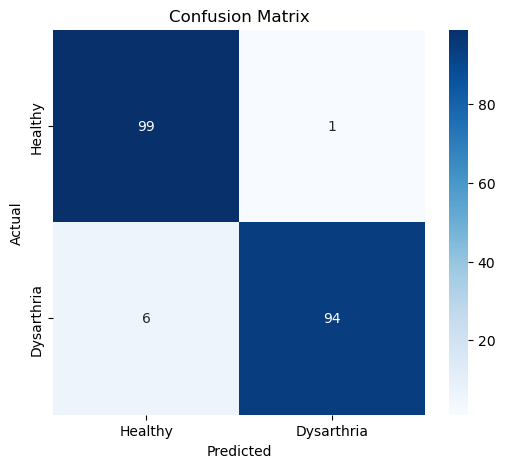

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get model predictions
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, attention_mask, labels in dataloader:
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            logits = model(input_values=inputs, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


y_pred, y_true = get_predictions(wav2vec_model, test_loader, device)
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Dysarthria"], yticklabels=["Healthy", "Dysarthria"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
